## ES和用户的地理位置分布

In [1]:
import sys
sys.path.append("../")
from simulator import env
from simulator.config import CANVAS_SIZE_X,CANVAS_SIZE_Y
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle

Load ./models/cache_agent/0/D3QN_q_eval.pth successfully!
Load ./models/cache_agent/0/D3QN_q_target.pth successfully!
Load ./models/maintainance_agent/0/D3QN_q_eval.pth successfully!
Load ./models/maintainance_agent/0/D3QN_q_target.pth successfully!
Load ./models/cache_agent/1/D3QN_q_eval.pth successfully!
Load ./models/cache_agent/1/D3QN_q_target.pth successfully!
Load ./models/maintainance_agent/1/D3QN_q_eval.pth successfully!
Load ./models/maintainance_agent/1/D3QN_q_target.pth successfully!
Load ./models/cache_agent/2/D3QN_q_eval.pth successfully!
Load ./models/cache_agent/2/D3QN_q_target.pth successfully!
Load ./models/maintainance_agent/2/D3QN_q_eval.pth successfully!
Load ./models/maintainance_agent/2/D3QN_q_target.pth successfully!
Load ./models/cache_agent/3/D3QN_q_eval.pth successfully!
Load ./models/cache_agent/3/D3QN_q_target.pth successfully!
Load ./models/maintainance_agent/3/D3QN_q_eval.pth successfully!
Load ./models/maintainance_agent/3/D3QN_q_target.pth successfully!


In [29]:
#env.reset()

with open('./figures/env.pkl', 'rb') as f:
    env = pickle.load(f)

In [28]:

for id, es in env.edge_servers.items():
    es.cache_agent= None
    es.maintainance_agent = None

env.writer = None

# 保存
with open('./figures/env.pkl', 'wb') as f:
    pickle.dump(env, f)

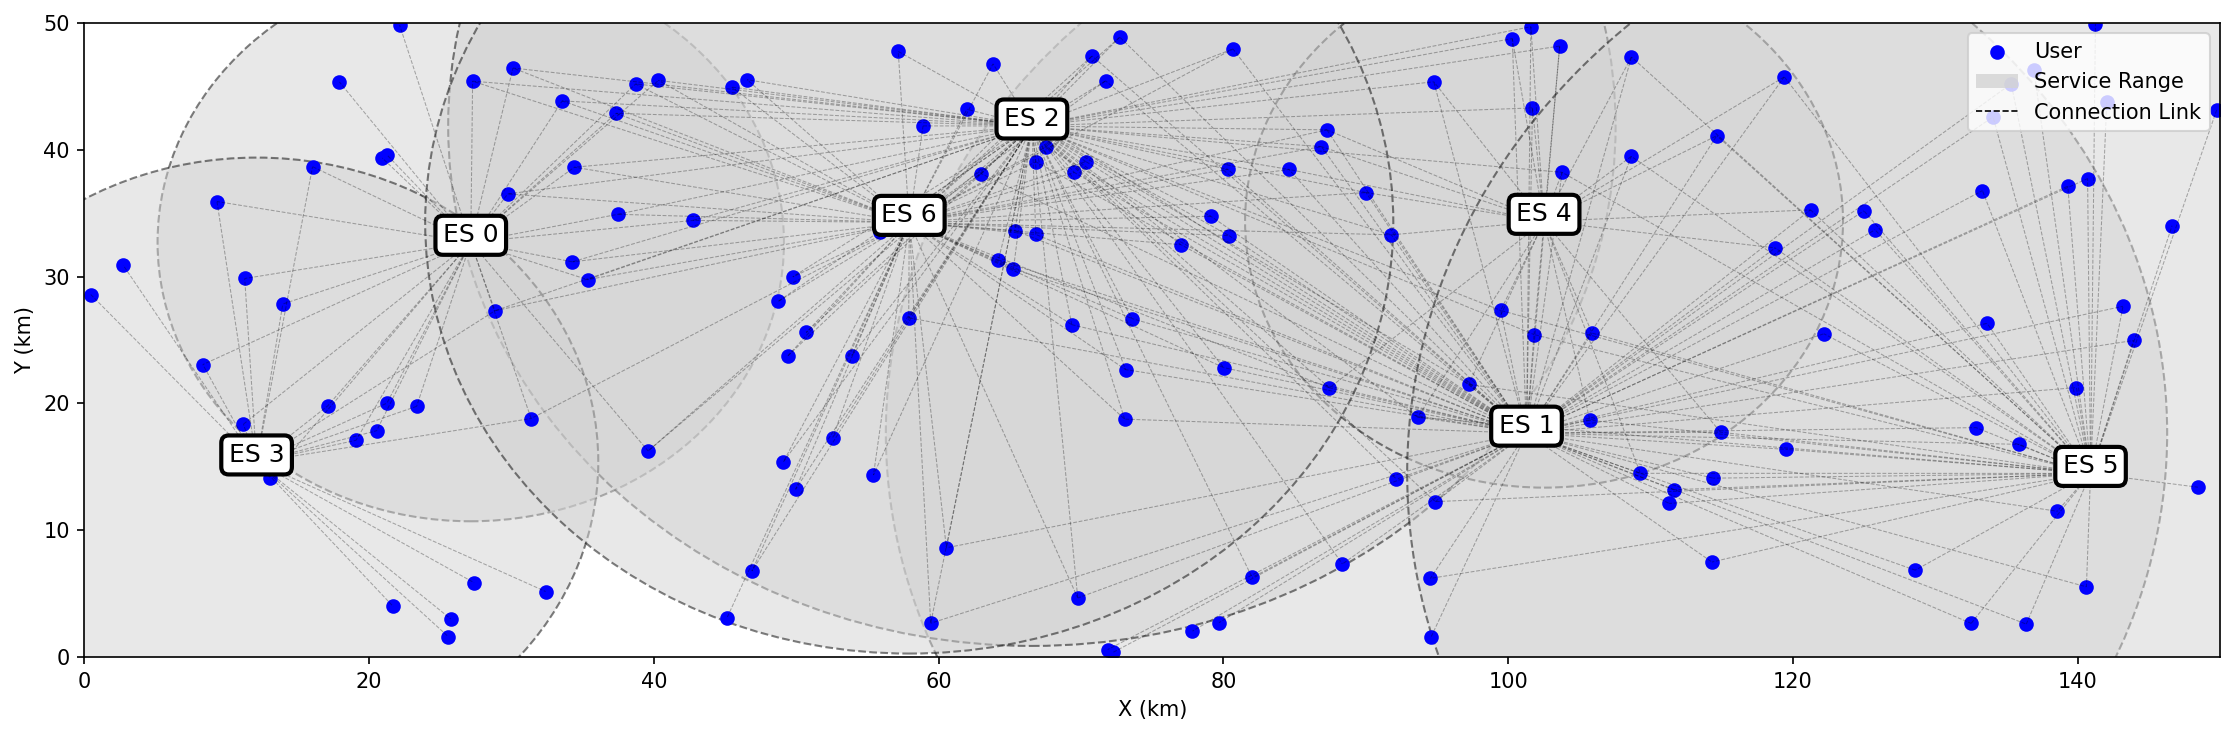

In [32]:
plt.figure(figsize=(CANVAS_SIZE_X/10, CANVAS_SIZE_Y/10), dpi=150)

for id, es in env.edge_servers.items():
    x, y = es.location
    range = es.service_range
    circle = plt.Circle((x, y), range,
                        facecolor='lightgrey',
                        alpha=0.5,
                        edgecolor='black',
                        fill=True, linestyle='--')
    plt.gcf().gca().add_artist(circle)

#for id, es in env.edge_servers.items():
#    x, y = es.location
#    plt.scatter(x, y, marker='x', color='red', label="Edge Server")


for user in env.users:
    x, y = user.location
    plt.scatter(x, y, marker='o', color='blue', label="User")
    servers = user.find_nearby_servers(env)
    for es, distance in servers:
        plt.plot([es.location[0], user.location[0]],
                 [es.location[1], user.location[1]],
                 color='black', linestyle='--',
                 alpha=0.3,
                 linewidth=0.5)

for id, es in env.edge_servers.items():
    x, y = es.location
    text_x, text_y = x, y  # 提示：这里去掉这一行
    text_box = plt.text(text_x, text_y, f"ES {id}", ha='center', fontsize=12)
    bbox_props = dict(boxstyle='round,pad=0.3',
                      fc='white', ec='black', lw=2)  # 设置文本框样式
    # 调整文本框位置，使其在圆形顶部
    text_box.set_bbox(bbox_props)
    text_box.set_position((x, y))

plt.legend(handles=[
    plt.scatter([], [], marker='o', color='blue', label="User"),
    mpatches.Rectangle((0,0), 1, 1, fc="lightgrey",alpha=0.8, label="Service Range"),
    plt.Line2D([], [], color='black', linestyle='--',
               linewidth=0.8, label="Connection Link")
    #plt.Circle((0,0),1,fill=False,label="Service Range")
], loc='upper right')
plt.xlim(0, CANVAS_SIZE_X)
plt.ylim(0, CANVAS_SIZE_Y)
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.tight_layout()
#plt.show()

plt.savefig("./figures/es_distribution.png", dpi=150)

In [33]:
for id, es in env.edge_servers.items():
    print(es.description)

# 每个边缘服务器的范围内的用户数量
res = {}
for id, es in env.edge_servers.items():
    res[id] = 0

for user in env.users:
    servers = user.find_nearby_servers(env)
    for es, distance in servers:
        res[es.id] += 1

print(res)


EdgeServer id：0
Max connections: 197
Location: (27.136266740297334, 32.707280329396596)
Faulty: False
Service range: 22 km
Storage (memory, SSD, HDD): (16, 256, 1000) GB
Storage speed (memory, SSD, HDD): (21000, 885, 271) mB/s
Bandwidth: 3311.59580574358 mB/s
Speed limit: -1 mB/s
Stablity: 1

EdgeServer id：1
Max connections: 185
Location: (101.29033024722284, 17.65732377238093)
Faulty: False
Service range: 45 km
Storage (memory, SSD, HDD): (8, 32, 1000) GB
Storage speed (memory, SSD, HDD): (8000, 1024, 206) mB/s
Bandwidth: 7529.599393430877 mB/s
Speed limit: -1 mB/s
Stablity: 1

EdgeServer id：2
Max connections: 142
Location: (66.5487095645409, 41.879136817387284)
Faulty: False
Service range: 41 km
Storage (memory, SSD, HDD): (4, 32, 700) GB
Storage speed (memory, SSD, HDD): (12000, 1456, 273) mB/s
Bandwidth: 6480.548508994145 mB/s
Speed limit: -1 mB/s
Stablity: 1

EdgeServer id：3
Max connections: 112
Location: (12.093840723493528, 15.387354541812845)
Faulty: False
Service range: 24 km


## RL收敛

In [66]:
import numpy as np

def average_filter(data, window_size):
    """平均滤波函数
    
    Args:
        data (np.ndarray): 输入的数据，shape为(n,)
        window_size (int): 窗口大小
        
    Returns:
        np.ndarray: 平滑后的数据，shape为(n,)
    """
    result = np.zeros_like(data)
    for i in range(window_size // 2, len(data) - window_size // 2):
        result[i] = np.mean(data[i - window_size // 2: i + window_size // 2])
    return result

def expo_filter(data, alpha):
    """指数滤波函数
    
    Args:
        data (np.ndarray): 输入的数据，shape为(n,)
        alpha (float): 平滑因子，取值在(0, 1]之间
        
    Returns:
        np.ndarray: 平滑后的数据，shape为(n,)
    """
    result = np.zeros_like(data)
    result[0] = data[0]
    for i in range(1, len(data)):
        result[i] = alpha * data[i] + (1 - alpha) * result[i - 1]
    return result

def find_nearest(array,v):
    """找到array中距离v最近的值的索引
    
    Args:
        array (np.ndarray): 输入的数据，shape为(n,)
        v (float): 目标值
        
    Returns:
        int: 最近的值的索引
    """
    return np.argmin(np.abs(array - v))

1067.0654296875
2366.43896484375


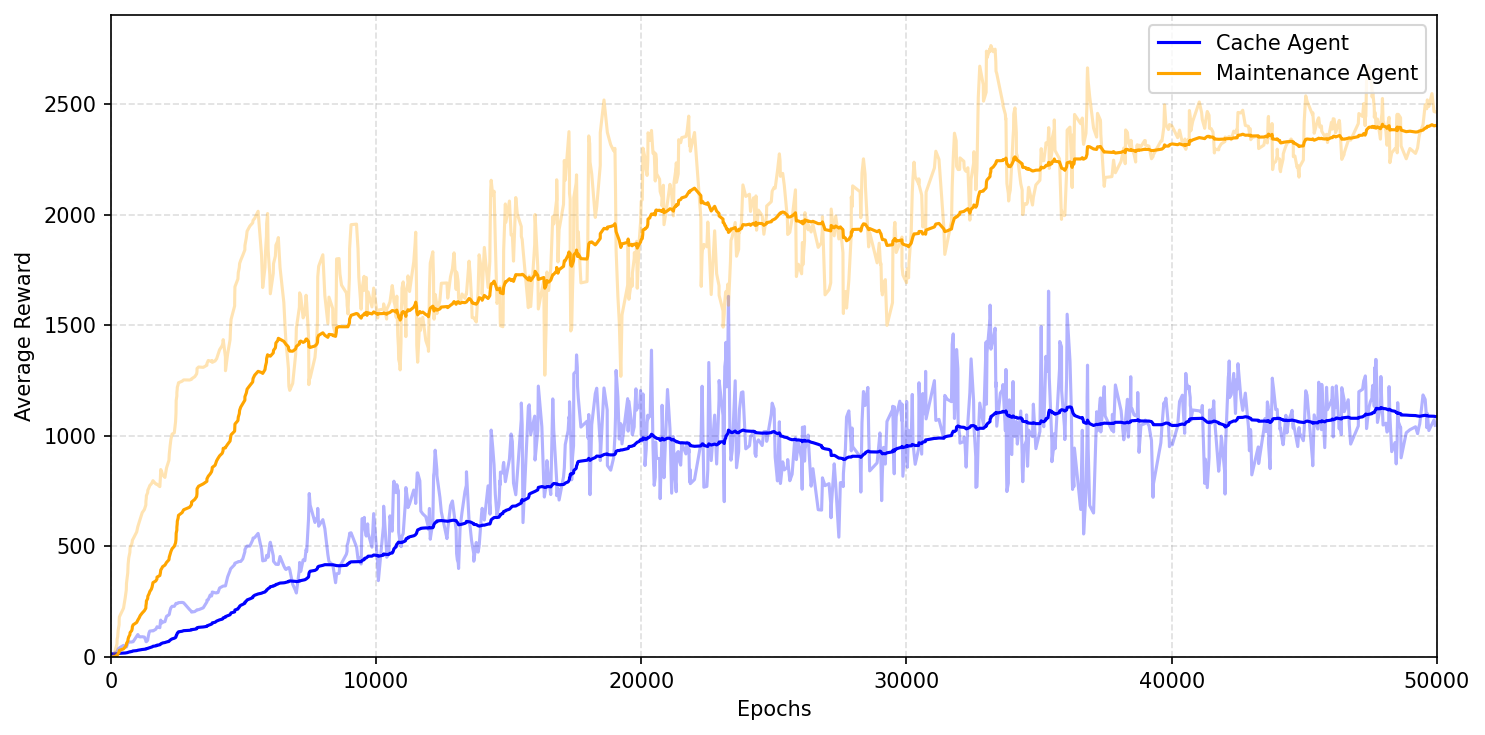

In [204]:
import json
import random
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5), dpi=150)

def load(filepath):
    with open(filepath, 'r') as f:
        agent_reward = json.load(f)
    timestamp = [t[1] for t in agent_reward]
    reward = [t[2] for t in agent_reward]
    return np.array(timestamp), np.array(reward)


cache_agent_timestamp,cache_agent_reward = load('./May06_05-11-43_John-pc-tag-overall_cache_agent_reward.json')
end_idx = find_nearest(cache_agent_timestamp, 50000)
cache_agent_timestamp = cache_agent_timestamp[:end_idx]
cache_agent_reward = cache_agent_reward[:end_idx]
cache_agent_reward*=1.5
index=find_nearest(cache_agent_timestamp,38000)
stable_val = cache_agent_reward[index]
print(stable_val)
filterd = expo_filter(cache_agent_reward,0.02)
cache_agent_reward[index:-1]+=stable_val-filterd[index:-1] # 修正指数滤波的稳态值
cache_agent_reward[index:-1]=stable_val+(stable_val-cache_agent_reward[index:-1])/2 # 修正指数滤波的稳态值

plt.plot(cache_agent_timestamp, expo_filter(cache_agent_reward,0.7),color="blue",alpha=0.3)
plt.plot(cache_agent_timestamp, expo_filter(cache_agent_reward,0.02),color="blue", label="Cache Agent")

maintainance_agent_timestamp,maintainance_agent_reward = load('./May06_05-11-43_John-pc-tag-overall_maintainance_agent_reward.json')
end_idx = find_nearest(maintainance_agent_timestamp, 50000)
maintainance_agent_timestamp = maintainance_agent_timestamp[:end_idx]
maintainance_agent_reward = maintainance_agent_reward[:end_idx]
index=find_nearest(maintainance_agent_timestamp,38000)
stable_val = maintainance_agent_reward[index]
print(stable_val)
filtered = expo_filter(maintainance_agent_reward,0.02)
maintainance_agent_reward[index:-1]+=stable_val-filtered[index:-1] # 修正指数滤波的稳态值
maintainance_agent_reward[index:-1]=stable_val+(stable_val-maintainance_agent_reward[index:-1])*np.random.uniform(-1,1,len(maintainance_agent_reward)-index-1) # 修正指数滤波的稳态值
plt.plot(maintainance_agent_timestamp,expo_filter(maintainance_agent_reward,0.2),color="orange",alpha=0.3)
plt.plot(maintainance_agent_timestamp,expo_filter(maintainance_agent_reward,0.02),color="orange",label="Maintenance Agent")

#网格
plt.grid(linestyle='--', alpha=0.4)
#从0开始
plt.xlim(0, 50000)
plt.ylim(0, )
plt.xlabel("Epochs")
plt.ylabel("Average Reward")
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("./overall_reward.png", dpi=150)
plt.show()